In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Preprocessing

In [ ]:
#현지용
feature = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/dataset/0815/0817_X_imputed.csv') 
optimal_gastro = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/dataset/0815/0817_optimal_target.csv') 
real_gastro = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/dataset/0725/real-target.csv의 사본') 
surv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/survival.csv')

In [2]:
#원준용
from google.colab import files 
uploaded = files.upload()

Saving 0817_optimal_target.csv to 0817_optimal_target.csv
Saving 0817_real-target.csv to 0817_real-target.csv
Saving 0817_X_imputed.csv to 0817_X_imputed.csv
Saving survival.csv to survival.csv


In [3]:
#원준용
import io
feature = pd.read_csv(io.BytesIO(uploaded['0817_X_imputed.csv'])) 
optimal_gastro = pd.read_csv(io.BytesIO(uploaded['0817_optimal_target.csv'])) 
real_gastro = pd.read_csv(io.BytesIO(uploaded['0817_real-target.csv']))
surv =  pd.read_csv(io.BytesIO(uploaded['survival.csv']))

In [4]:
optimal_gastro.drop(columns='Unnamed: 0', inplace=True)
real_gastro.drop(columns='Unnamed: 0', inplace=True)
feature.drop(columns='Unnamed: 0', inplace=True)

feature.drop(columns='onset_site', inplace=True)
feature['mean_Q1_2_3_mouth'] = feature['mean_Q1_Speech'] + feature['mean_Q2_Salivation'] + feature['mean_Q3_Swallowing']

In [5]:
pip install lifelines

     |████████████████████████████████| 348 kB 5.3 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=a6032217de018e1fc4a8095f03344a70ffcecc58fa021d5a77b15bef25e621a5
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [6]:
print("There are",len(feature),"patients with feature") # There are 4088 patients with feature
print("There are",len(optimal_gastro),"patients with opt-gas value") # There are 4523 patients with opt-gas value
print("There are",len(real_gastro),"patients with real-gas value") # There are 5027 patients with real-gas value
feature_real = feature.merge(real_gastro, on='SubjectID', how='inner')
print("There are",len(feature_real),"patients with feature & real value 1:",len(feature_real[feature_real['status_real']==1]),"0:", len(feature_real[feature_real['status_real']==0])) # There are 2941 patients with feature & real value 1: 475 0: 2466

There are 4088 patients with feature
There are 4523 patients with opt-gas value
There are 5027 patients with real-gas value
There are 2941 patients with feature & real value 1: 475 0: 2466


## 1-1. Calculate predicted optimal time for patients

In [7]:
# train data for model predicting optimal gas time
feature_opt = feature.merge(optimal_gastro, on='SubjectID', how='inner')
feature_opt.query('time_opt !=0', inplace=True)

df_train = feature_opt.copy()
df_train = df_train[['Age', 'onset_delta', 'fvc_mean',  'mean_Q1_2_3_mouth', 'mean_Q7_Turning_in_Bed', 'slope_Q1_Speech',
                       'slope_Q3_Swallowing', 'weight_slope', 'time_opt', 'status_opt']]
df_train

,Age,onset_delta,fvc_mean,mean_Q1_2_3_mouth,mean_Q7_Turning_in_Bed,slope_Q1_Speech,slope_Q3_Swallowing,weight_slope,time_opt,status_opt
0,4.0,-56.087671,101.250000,11.000000,2.600000,0.000000,0.000000,-2.703704,274,0
1,6.0,-35.178082,51.000000,8.500000,4.000000,0.000000,-0.334249,-3.309066,35,1
2,12.0,-16.898630,89.600000,11.000000,4.000000,0.000000,0.362103,-0.601648,154,0
3,5.0,-18.739726,71.000000,8.500000,0.500000,-0.633681,0.000000,-1.933900,187,1
4,9.0,-12.000000,114.000000,12.000000,3.000000,0.000000,0.000000,0.000000,401,0
...,...,...,...,...,...,...,...,...,...,...
2558,9.0,-20.120548,73.333333,8.333333,4.000000,0.000000,0.000000,1.310900,64,0
2559,9.0,-32.843836,75.000000,10.000000,3.000000,0.010513,0.164577,-3.206060,390,0
2560,8.0,-16.175342,100.800000,8.500000,4.000000,-0.370935,-0.370935,-0.534799,91,1
2561,7.0,-94.191781,50.250000,12.000000,2.800000,0.000000,0.000000,-0.217262,266,0


In [8]:
# input data for trained model
df_input = feature_real[['Age', 'onset_delta', 'fvc_mean',  'mean_Q1_2_3_mouth', 'mean_Q7_Turning_in_Bed', 'slope_Q1_Speech',
                       'slope_Q3_Swallowing', 'weight_slope']]
df_input

,Age,onset_delta,fvc_mean,mean_Q1_2_3_mouth,mean_Q7_Turning_in_Bed,slope_Q1_Speech,slope_Q3_Swallowing,weight_slope
0,4.0,-56.087671,101.250000,11.000000,2.600000,0.000000,0.000000,-2.703704
1,7.0,-16.471233,118.746612,12.000000,3.500000,0.000000,0.000000,1.844945
2,10.0,-33.632877,73.500000,4.333333,4.000000,-0.334249,0.000000,-0.167125
3,6.0,-35.178082,51.000000,8.500000,4.000000,0.000000,-0.334249,-3.309066
4,9.0,-12.000000,114.000000,12.000000,3.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2936,9.0,-11.210959,125.750000,12.000000,3.600000,0.000000,0.000000,-1.564286
2937,5.0,-21.468493,67.000000,12.000000,2.125000,0.000000,0.000000,-1.153736
2938,9.0,-32.843836,75.000000,10.000000,3.000000,0.010513,0.164577,-3.206060
2939,7.0,-94.191781,50.250000,12.000000,2.800000,0.000000,0.000000,-0.217262


In [9]:
# Train model
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.1, l1_ratio=0.2)
cph.fit(df_train, 'time_opt', event_col='status_opt')

<lifelines.CoxPHFitter: fitted with 2563 total observations, 1717 right-censored observations>

In [11]:
# median optimal time is predicted by trained model
cph_median = pd.concat([feature_real['SubjectID'],cph.predict_median(df_input)], axis=1)
cph_median.columns = ['SubjectID', 'predicted_opt']
cph_median_without_inf = cph_median[cph_median['predicted_opt']!=np.inf]
feat_real_optpred = feature_real.merge(cph_median_without_inf, on='SubjectID', how='inner')
feat_real_optpred['delayed_gas'] = feat_real_optpred['time_real']-feat_real_optpred['predicted_opt']
print('There are ', len(cph_median[cph_median['predicted_opt']==np.inf]), 'inf values which have been removed')
 # There are  8 inf values which have been removed
print(cph_median_without_inf)

There are  8 inf values which have been removed
      SubjectID  predicted_opt
0         329.0          922.0
1         348.0         1188.0
2         533.0           95.0
3         708.0          272.0
4        2492.0          867.0
...         ...            ...
2936   998506.0          909.0
2937   998519.0          692.0
2938   999166.0          417.0
2939   999880.0         1647.0
2940   999990.0          417.0

[2933 rows x 2 columns]


## 1-2. Merge (real gas/ predicted optimal gas / survival) & Define delayed gas

In [12]:
feat_real_optpred = feature_real.merge(cph_median_without_inf, on='SubjectID', how='inner')
feat_real_optpred['delayed_gas'] = feat_real_optpred['time_real']-feat_real_optpred['predicted_opt'] # Delayed gas is defined as time differece between 'predicted opt' and 'time real'
feat_real_optpred # 2933 data

,SubjectID,Age,Gender,diag_delta,onset_delta,diag_minus_onset,fvc_slope,fvc_mean,Creatinine_mean,Creatinine_slope,alsfrs_total_slope,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,weight_slope,mean_Q1_2_3_mouth,time_real,status_real,predicted_opt,delayed_gas
0,329.0,4.0,0.0,-35.112329,-56.087671,20.975342,1.465187,101.250000,58.933333,-37.344907,1.739251,4.0,3.000000,4.000000,3.000000,1.90,3.000000,2.600000,2.000000,1.200000,3.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.844907,0.000000,0.422454,0.000000,-2.703704,11.000000,274,0,922.0,-648.0
1,348.0,7.0,0.0,-9.928767,-16.471233,6.542466,17.635828,118.746612,53.040000,0.000000,-0.294720,4.0,4.000000,4.000000,3.500000,2.00,2.250000,3.500000,2.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.498634,0.000000,-0.498634,-0.498634,0.000000,0.000000,0.000000,1.844945,12.000000,401,0,1188.0,-787.0
2,533.0,10.0,0.0,-1.446575,-33.632877,32.186301,-17.743056,73.500000,79.560000,0.000000,0.064293,1.0,1.333333,2.000000,4.000000,4.00,3.333333,4.000000,3.333333,2.666667,3.000000,-0.334249,-0.334249,0.000000,0.000000,0.000000,-0.334249,0.000000,0.334249,0.334249,0.000000,-0.167125,4.333333,287,1,95.0,192.0
3,708.0,6.0,1.0,-32.416438,-35.178082,2.761644,-1.883650,51.000000,88.400000,0.000000,-0.457380,3.0,2.833333,2.666667,3.166667,3.75,3.166667,4.000000,4.000000,2.833333,2.833333,0.000000,-0.334249,-0.334249,0.000000,0.000000,0.334249,0.000000,0.000000,0.000000,-0.334249,-3.309066,8.500000,231,0,272.0,-41.0
4,2492.0,9.0,1.0,-6.871233,-12.000000,5.128767,-7.156863,114.000000,66.300000,7.908333,0.000000,4.0,4.000000,4.000000,3.000000,3.00,2.000000,3.000000,3.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,401,0,867.0,-466.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,998506.0,9.0,1.0,-10.191781,-11.210959,1.019178,3.277341,125.750000,88.400000,0.000000,-0.858942,4.0,4.000000,4.000000,3.000000,3.00,2.300000,3.600000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.434524,-0.434524,0.000000,0.000000,0.000000,-1.564286,12.000000,266,0,909.0,-643.0
2929,998519.0,5.0,0.0,-15.616438,-21.468493,5.852055,-0.478924,67.000000,0.000000,0.000000,-2.046682,4.0,4.000000,4.000000,2.500000,2.75,2.375000,2.125000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,-0.699234,-0.349617,-0.349617,-0.699234,0.000000,0.000000,0.000000,-1.153736,12.000000,280,0,692.0,-412.0
2930,999166.0,9.0,1.0,-1.610959,-32.843836,31.232877,-10.138889,75.000000,83.980000,5.845290,-1.697827,3.0,3.000000,4.000000,4.000000,4.00,4.000000,3.000000,3.000000,3.000000,4.000000,0.010513,-0.010934,0.164577,-0.166495,0.122598,-0.431570,-0.653074,-0.657898,-1.002338,0.421041,-3.206060,10.000000,390,0,417.0,-27.0
2931,999880.0,7.0,1.0,-69.205479,-94.191781,24.986301,-2.406327,50.250000,88.400000,0.000000,0.352317,4.0,4.000000,4.000000,2.000000,1.00,0.400000,2.800000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.434524,0.000000,0.000000,0.000000,0.000000,-0.217262,12.000000,266,0,1647.0,-1381.0


In [13]:
feat_dg_surv = feat_real_optpred.merge(surv, on='SubjectID', how='inner') # 'dg' states for delayed gastrostomy
feat_dg_surv #2930 data

,SubjectID,Age,Gender,diag_delta,onset_delta,diag_minus_onset,fvc_slope,fvc_mean,Creatinine_mean,Creatinine_slope,alsfrs_total_slope,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,weight_slope,mean_Q1_2_3_mouth,time_real,status_real,predicted_opt,delayed_gas,time_event,status
0,329.0,4.0,0.0,-35.112329,-56.087671,20.975342,1.465187,101.250000,58.933333,-37.344907,1.739251,4.0,3.000000,4.000000,3.000000,1.90,3.000000,2.600000,2.000000,1.200000,3.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.844907,0.000000,0.422454,0.000000,-2.703704,11.000000,274,0,922.0,-648.0,274,0
1,348.0,7.0,0.0,-9.928767,-16.471233,6.542466,17.635828,118.746612,53.040000,0.000000,-0.294720,4.0,4.000000,4.000000,3.500000,2.00,2.250000,3.500000,2.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.498634,0.000000,-0.498634,-0.498634,0.000000,0.000000,0.000000,1.844945,12.000000,401,0,1188.0,-787.0,401,0
2,533.0,10.0,0.0,-1.446575,-33.632877,32.186301,-17.743056,73.500000,79.560000,0.000000,0.064293,1.0,1.333333,2.000000,4.000000,4.00,3.333333,4.000000,3.333333,2.666667,3.000000,-0.334249,-0.334249,0.000000,0.000000,0.000000,-0.334249,0.000000,0.334249,0.334249,0.000000,-0.167125,4.333333,287,1,95.0,192.0,378,0
3,708.0,6.0,1.0,-32.416438,-35.178082,2.761644,-1.883650,51.000000,88.400000,0.000000,-0.457380,3.0,2.833333,2.666667,3.166667,3.75,3.166667,4.000000,4.000000,2.833333,2.833333,0.000000,-0.334249,-0.334249,0.000000,0.000000,0.334249,0.000000,0.000000,0.000000,-0.334249,-3.309066,8.500000,231,0,272.0,-41.0,250,1
4,2492.0,9.0,1.0,-6.871233,-12.000000,5.128767,-7.156863,114.000000,66.300000,7.908333,0.000000,4.0,4.000000,4.000000,3.000000,3.00,2.000000,3.000000,3.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,401,0,867.0,-466.0,401,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,998506.0,9.0,1.0,-10.191781,-11.210959,1.019178,3.277341,125.750000,88.400000,0.000000,-0.858942,4.0,4.000000,4.000000,3.000000,3.00,2.300000,3.600000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.434524,-0.434524,0.000000,0.000000,0.000000,-1.564286,12.000000,266,0,909.0,-643.0,266,0
2926,998519.0,5.0,0.0,-15.616438,-21.468493,5.852055,-0.478924,67.000000,0.000000,0.000000,-2.046682,4.0,4.000000,4.000000,2.500000,2.75,2.375000,2.125000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,-0.699234,-0.349617,-0.349617,-0.699234,0.000000,0.000000,0.000000,-1.153736,12.000000,280,0,692.0,-412.0,280,0
2927,999166.0,9.0,1.0,-1.610959,-32.843836,31.232877,-10.138889,75.000000,83.980000,5.845290,-1.697827,3.0,3.000000,4.000000,4.000000,4.00,4.000000,3.000000,3.000000,3.000000,4.000000,0.010513,-0.010934,0.164577,-0.166495,0.122598,-0.431570,-0.653074,-0.657898,-1.002338,0.421041,-3.206060,10.000000,390,0,417.0,-27.0,390,0
2928,999880.0,7.0,1.0,-69.205479,-94.191781,24.986301,-2.406327,50.250000,88.400000,0.000000,0.352317,4.0,4.000000,4.000000,2.000000,1.00,0.400000,2.800000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.434524,0.000000,0.000000,0.000000,0.000000,-0.217262,12.000000,266,0,1647.0,-1381.0,266,0


# 2. Analysis on Survival effect of delayed gastrostomy

In [14]:
# Filter with (time real, predicted opt < time event for survival) 
feat_dg_surv_filtered = feat_dg_surv[feat_dg_surv['time_real']<feat_dg_surv['time_event']]
feat_dg_surv_filtered = feat_dg_surv_filtered[feat_dg_surv_filtered['predicted_opt']<feat_dg_surv_filtered['time_event']]
print(len(feat_dg_surv_filtered), 'are left, while', len(feat_dg_surv)-len(feat_dg_surv_filtered), "are removed for censoring")

466 are left, while 2464 are removed for censoring


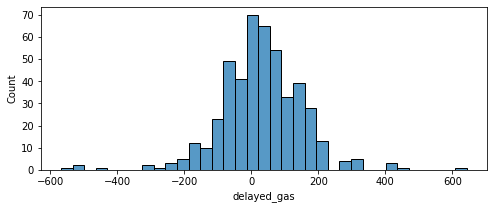

In [15]:
plt.figure(figsize=(8, 3))
sns.histplot(feat_dg_surv_filtered['delayed_gas'])

## 2-1. brief observation: Correlation between survival time and delayed gas

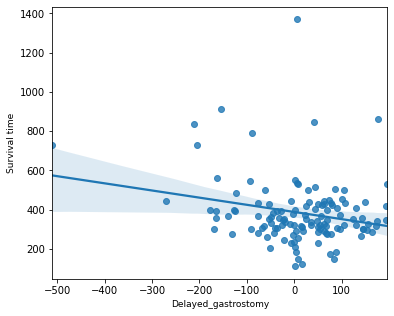

In [16]:
scat_df = feat_dg_surv_filtered.query('status==1 and status_real==1')
fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(x=scat_df['delayed_gas'], y=scat_df['time_event'], fit_reg=True) 
plt.xlabel('Delayed_gastrostomy', fontsize=9)
plt.ylabel('Survival time', fontsize=9)
plt.show()

## 2-2. Group estimation by Kaplan-Meier

In [17]:
f_d_s_f_real_1 = feat_dg_surv_filtered[feat_dg_surv_filtered['status_real']==1]
print(f_d_s_f_real_1['delayed_gas'].describe())

# 25%      -46.000000
# 50%       29.000000
# 75%       90.000000

count    293.000000
mean      25.430034
std      104.382067
min     -510.000000
25%      -46.000000
50%       29.000000
75%       90.000000
max      404.000000
Name: delayed_gas, dtype: float64


In [18]:
# Early / Medium / Late group with 25/50/25 percentile
feature_early= f_d_s_f_real_1[f_d_s_f_real_1['delayed_gas']<= -46]
feature_medium= f_d_s_f_real_1.query('(delayed_gas > -46) and (delayed_gas <= 90)')
feature_late= f_d_s_f_real_1[feat_dg_surv_filtered['delayed_gas']> 90]

early_list= list(feature_early['SubjectID'])
medium_list= list(feature_medium['SubjectID'])
late_list= list(feature_late['SubjectID'])+list(feat_dg_surv_filtered[feat_dg_surv_filtered['status_real']==0].query('delayed_gas >90')['SubjectID']) # Patients in (status_real, status_opt) = (0. 1)  who satisfied criterion were added for late group
 
surv_early = feat_dg_surv_filtered.query("SubjectID == {0}".format(early_list))
surv_medium = feat_dg_surv_filtered.query("SubjectID == {0}".format(medium_list))
surv_late = feat_dg_surv_filtered.query("SubjectID == {0}".format(late_list))

print("Subjects are categorized  ", len(surv_early), "(25% Early)", len(surv_medium), '(50% Medium)', len(surv_late), '(25+a% Late)')
 # Subjects are categorized   74 (25% Early) 146 (50% Medium) 123 (25+a% Late)

Subjects are categorized   74 (25% Early) 146 (50% Medium) 123 (25+a% Late)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


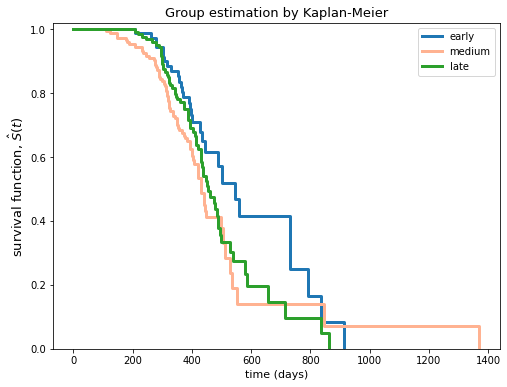

The plot above suggests a time-varying effect of delayed gastrostomy for survival event.


In [19]:
from lifelines import KaplanMeierFitter
plt.figure(figsize=(8, 6))
kmf = KaplanMeierFitter()

kmf.fit(surv_early["time_event"], surv_early["status"], label="early",alpha=1)
ax_kmf = kmf.plot(linewidth=3)
kmf.fit(surv_medium["time_event"], surv_medium["status"], label="medium",alpha=1)
ax_kmf = kmf.plot(ax=ax_kmf, color='#FFB291',linewidth=3)
kmf.fit(surv_late["time_event"], surv_late["status"], label="late",alpha=1)
ax_kmf = kmf.plot(ax=ax_kmf, linewidth=3)

ax_kmf.set_ylim(0,1.02)
ax_kmf.set_xlim()
ax_kmf.set_xlabel('time (days)', fontsize=11)
ax_kmf.set_ylabel('survival function, $\hat{S}(t)$', fontsize=13)
plt.title('Group estimation by Kaplan-Meier', fontsize=13)
plt.show()
print('The plot above suggests a time-varying effect of delayed gastrostomy for survival event.')

In [20]:
from lifelines.statistics import logrank_test
logrank_test(surv_early["time_event"], surv_late["time_event"], surv_early["status"], surv_late["status"]).p_value
# p_value = 0.0656232640715018

0.0656232640715018